# Feature Engineering with some Preliminary Modeling
    * Feature addition 
    * RandomForest hyper parameter grid searches to prepare for recursive feature elimination
    * 3-class and 2-class classification modeling
    * Recursive feature elimination, feature importance plots
    * Rank2D covariance plot
    * RadViz data separability plot
    * Saving out dataframes for modeling: 
        * dataset_minimal_features_for_modeling.csv (df_minimal in the paper) 
        * dataset_max_features_for_modeling.csv (df_large in the paper)

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from yellowbrick.regressor import residuals_plot, ResidualsPlot
%matplotlib inline

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler,PolynomialFeatures
from feature_engine.encoding import OneHotEncoder
from feature_engine.wrappers import SklearnTransformerWrapper
from sklearn.metrics import mean_squared_error

In [2]:
pd.set_option("display.max_columns", 99)
df = pd.read_csv("../data/dataset_from_ingestion.csv")
df.head(n=3)


,Year,Stnam,Fipst,Leaid,Leanm,Ncessch,Schnam,All_Cohort,School_Name,Zip_Mailing,Zip_Location,Latitude,Urban_Centric_Locale,County_Code,School_Level,School_Type,Lowest_Grade_Offered,Highest_Grade_Offered,Title_I_Status,Title_I_Eligible,Charter,Magnet,Virtual,Teachers_Fte,Free_Lunch,Reduced_Price_Lunch,Free_Or_Reduced_Price_Lunch,Enrollment,Ungrade_Cedp,Math_Pct_Part,Rla_Pct_Part,Rural_Urban_Continuum_Code,Urban_Influence_Code,Metro_Or_Not,Civilian_Labor_Force,Unemployment_Rate,Grad_Rate
0,2012,ALASKA,2,200001,Lower Kuskokwim School District,20000100208,Bethel Regional High School,75,BETHEL REGIONAL HIGH SCHOOL,99559.0,99559.0,60.802584,41.0,2050.0,4.0,1.0,6.0,12.0,5.0,1.0,0.0,0.0,0.0,32.849998,210.0,28.0,238.0,506.0,0.0,97.5,97.5,7.0,11.0,0.0,7193.0,15.6,52.0
1,2012,ALASKA,2,200001,Lower Kuskokwim School District,20000100318,Bethel Alternative Boarding School,28,BETHEL ALTERNATIVE BOARDING SCHOOL,99559.0,99559.0,60.795960,33.0,2050.0,3.0,4.0,8.0,12.0,5.0,1.0,0.0,0.0,0.0,4.000000,58.0,0.0,58.0,61.0,0.0,90.0,90.0,7.0,11.0,0.0,7193.0,15.6,10.0
2,2012,ALASKA,2,200006,Mount Edgecumbe High School Agency,20000600558,Mt. Edgecumbe High School,71,MT. EDGECUMBE HIGH SCHOOL,99835.0,99835.0,57.051810,41.0,2220.0,3.0,1.0,9.0,12.0,5.0,1.0,0.0,0.0,0.0,22.500000,224.0,35.0,259.0,398.0,0.0,97.5,97.5,7.0,11.0,0.0,4627.0,5.7,97.5


# Drop geographic and duplicate columns, leaving only a few school identifiers (e.g. School Name) and our data we want to model

In [3]:
df.drop(["Zip_Mailing", "Zip_Location", "Latitude", "School_Name",
        "Leaid", "Leanm", "Fipst", "County_Code"], axis=1, inplace=True)


In [4]:
df.head(n=2)
print(df.shape)


(83658, 29)


# New Feature Creation

In [5]:
# Create features by dividing one column by another or subtracting one column from another.

df["Teacher_Ratio1"] = df.Teachers_Fte / df.Enrollment
df["Teacher_Ratio2"] = df.Teachers_Fte / df.All_Cohort
df["Num_Grades"] = df.Highest_Grade_Offered - df.Lowest_Grade_Offered


In [6]:
df.dtypes


Year                             int64
Stnam                           object
Ncessch                          int64
Schnam                          object
All_Cohort                       int64
Urban_Centric_Locale           float64
School_Level                   float64
School_Type                    float64
Lowest_Grade_Offered           float64
Highest_Grade_Offered          float64
Title_I_Status                 float64
Title_I_Eligible               float64
Charter                        float64
Magnet                         float64
Virtual                        float64
Teachers_Fte                   float64
Free_Lunch                     float64
Reduced_Price_Lunch            float64
Free_Or_Reduced_Price_Lunch    float64
Enrollment                     float64
Ungrade_Cedp                   float64
Math_Pct_Part                  float64
Rla_Pct_Part                   float64
Rural_Urban_Continuum_Code     float64
Urban_Influence_Code           float64
Metro_Or_Not             

# Prepare dataframes and train-test split for modeling

In [7]:
def Make_X_y(df: pd.DataFrame):
    """
    # Subset to features used in modeling. 
    # Tag categoricals to the pandas type categorical. 
    """

    X = df.copy()

    X.drop(
        [
            "Stnam",
            "Ncessch",
            "Schnam",
            "Year",
        ],
        inplace=True,
        axis=1,
    )

    y = X.pop("Grad_Rate")

    # Tag categoricals so that they can be treated properly by the modeling packages
    categoricals = ['Urban_Centric_Locale', 'School_Level', 'School_Type', 'Title_I_Status', 'Title_I_Eligible',
                    'Charter', 'Magnet', 'Virtual', 'Ungrade_Cedp', 'Rural_Urban_Continuum_Code', 'Urban_Influence_Code', 'Metro_Or_Not']

    # Convert categoricals to the pandas type 'category'
    for col in categoricals:
        X[col] = X[col].astype("category")

    # Create train-test split
    Xtrain, Xtest, ytrain, ytest = train_test_split(
        X, y, test_size=0.30, stratify=y, random_state=42
    )
    return X, y, Xtrain, Xtest, ytrain, ytest


In [8]:
X, y, Xtrain, Xtest, ytrain, ytest = Make_X_y(df)
pd.set_option("display.max_rows", 999)
X.dtypes


All_Cohort                        int64
Urban_Centric_Locale           category
School_Level                   category
School_Type                    category
Lowest_Grade_Offered            float64
Highest_Grade_Offered           float64
Title_I_Status                 category
Title_I_Eligible               category
Charter                        category
Magnet                         category
Virtual                        category
Teachers_Fte                    float64
Free_Lunch                      float64
Reduced_Price_Lunch             float64
Free_Or_Reduced_Price_Lunch     float64
Enrollment                      float64
Ungrade_Cedp                   category
Math_Pct_Part                   float64
Rla_Pct_Part                    float64
Rural_Urban_Continuum_Code     category
Urban_Influence_Code           category
Metro_Or_Not                   category
Civilian_Labor_Force            float64
Unemployment_Rate               float64
Teacher_Ratio1                  float64


In [9]:
print("Instances in training set:", len(Xtrain))
Xtrain.head(n=2)


Instances in training set: 58560


,All_Cohort,Urban_Centric_Locale,School_Level,School_Type,Lowest_Grade_Offered,Highest_Grade_Offered,Title_I_Status,Title_I_Eligible,Charter,Magnet,Virtual,Teachers_Fte,Free_Lunch,Reduced_Price_Lunch,Free_Or_Reduced_Price_Lunch,Enrollment,Ungrade_Cedp,Math_Pct_Part,Rla_Pct_Part,Rural_Urban_Continuum_Code,Urban_Influence_Code,Metro_Or_Not,Civilian_Labor_Force,Unemployment_Rate,Teacher_Ratio1,Teacher_Ratio2,Num_Grades
28263,18,43.0,3.0,1.0,7.0,12.0,1.0,1.0,0.0,0.0,0.0,18.000000,58.0,21.0,79.0,146.0,0.0,90.0,90.0,9.0,12.0,0.0,1518.0,2.4,0.123288,1.00000,5.0
12172,40,42.0,3.0,1.0,7.0,12.0,5.0,1.0,0.0,0.0,0.0,32.709999,130.0,49.0,179.0,277.0,0.0,97.5,95.0,4.0,5.0,0.0,35304.0,7.6,0.118087,0.81775,5.0


# Preliminary Hyper-parameter tuning of RandomForest models 

In [10]:
def get_depth_for_memorization(instances_in_train_set, cv_number_of_training_groups):
    """ Return the uppermost max_depth to use to prevent memorizing training data """
    instances_being_fit = (instances_in_train_set /
                           cv_number_of_training_groups)
    depth_for_memorization = np.log2(instances_being_fit)
    return depth_for_memorization


In [11]:
get_depth_for_memorization(58560, 4)


13.837627933171404

In [12]:
# Create and run hyperparameter tuning pipeline
from sklearn.model_selection import GridSearchCV
import warnings
import joblib
import os

warnings.simplefilter(action="ignore", category=pd.errors.PerformanceWarning)
param_grid = {
    "rf__n_estimators": [300, 500, 800],
    "rf__max_features": [0.75, 0.3],
    "rf__max_depth": [1, 5, 9, 13],
    "rf__ccp_alpha": [0.0, 0.5],
    "rf__random_state": [42],
}
pipe = Pipeline(
    steps=[
        ("onehot", OneHotEncoder(drop_last=True, variables=Xtrain.select_dtypes(
            include='category').columns.tolist())),
        ("rf", RandomForestRegressor()),
    ]
)

# Load model from disk instead of running again.
clf = {}
local_model_path = (
    "../../student_outcome_saved_models/model_datasetB_random_forest_gridsearch1.pkl"
)
if os.path.exists(local_model_path):
    clf = joblib.load(local_model_path)
else:
    clf = GridSearchCV(
        pipe,
        param_grid,
        n_jobs=4,
        verbose=3,
        cv=4,
        scoring="r2",
    )
    clf.fit(Xtrain, ytrain)
    joblib.dump(clf, local_model_path)


Fitting 4 folds for each of 48 candidates, totalling 192 fits
[CV 1/4] END rf__ccp_alpha=0.0, rf__max_depth=1, rf__max_features=0.75, rf__n_estimators=300, rf__random_state=42;, score=0.380 total time=   5.6s
[CV 2/4] END rf__ccp_alpha=0.0, rf__max_depth=1, rf__max_features=0.75, rf__n_estimators=300, rf__random_state=42;, score=0.372 total time=   5.6s
[CV 4/4] END rf__ccp_alpha=0.0, rf__max_depth=1, rf__max_features=0.75, rf__n_estimators=300, rf__random_state=42;, score=0.376 total time=   5.6s
[CV 3/4] END rf__ccp_alpha=0.0, rf__max_depth=1, rf__max_features=0.75, rf__n_estimators=300, rf__random_state=42;, score=0.393 total time=   5.7s
[CV 1/4] END rf__ccp_alpha=0.0, rf__max_depth=1, rf__max_features=0.75, rf__n_estimators=500, rf__random_state=42;, score=0.379 total time=   9.8s
[CV 3/4] END rf__ccp_alpha=0.0, rf__max_depth=1, rf__max_features=0.75, rf__n_estimators=500, rf__random_state=42;, score=0.392 total time=   9.8s
[CV 4/4] END rf__ccp_alpha=0.0, rf__max_depth=1, rf__max

## Best parameters from GridSearch
    * First round: {'rf__ccp_alpha': 0.0, 'rf__max_depth': 100, 'rf__max_features': 60, 'rf__n_estimators': 500, 'rf__random_state': 42}
    * Second round: {'rf__ccp_alpha': 0.0, 'rf__max_depth': 90, 'rf__max_features': 55, 'rf__n_estimators': 500, 'rf__random_state': 42}
    * Third round: {'rf__ccp_alpha': 0.0, 'rf__max_depth': 35, 'rf__max_features': 55, 'rf__n_estimators': 1000
    'rf__random_state': 42}
    * Fourth round: {'rf__ccp_alpha': 0.0, 'rf__max_depth': 13, 'rf__max_features': 0.3, 'rf__n_estimators': 800 
    'rf__random_state': 42}

In [13]:
Xtrain.dtypes


All_Cohort                        int64
Urban_Centric_Locale           category
School_Level                   category
School_Type                    category
Lowest_Grade_Offered            float64
Highest_Grade_Offered           float64
Title_I_Status                 category
Title_I_Eligible               category
Charter                        category
Magnet                         category
Virtual                        category
Teachers_Fte                    float64
Free_Lunch                      float64
Reduced_Price_Lunch             float64
Free_Or_Reduced_Price_Lunch     float64
Enrollment                      float64
Ungrade_Cedp                   category
Math_Pct_Part                   float64
Rla_Pct_Part                    float64
Rural_Urban_Continuum_Code     category
Urban_Influence_Code           category
Metro_Or_Not                   category
Civilian_Labor_Force            float64
Unemployment_Rate               float64
Teacher_Ratio1                  float64


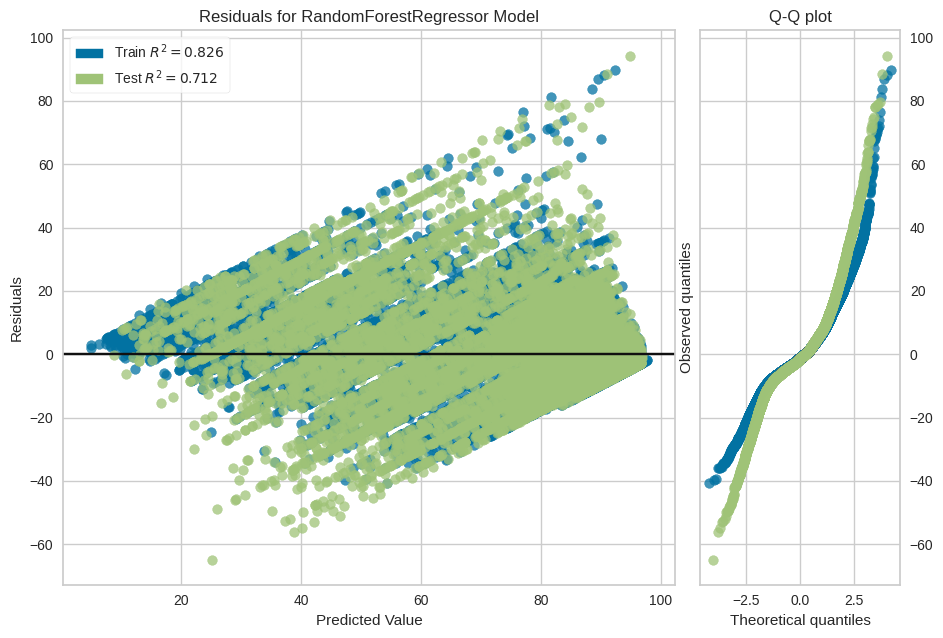

RMSE 10.431093939363457


In [14]:
# View The Results of GridSearch CV
clf.best_params_
plot_title = "Residuals for RandomForestRegressor before Feature Engineering (max_depth=13)"
visualizer = ResidualsPlot(
    clf.best_estimator_, hist=False, qqplot=True, size=(1080, 720))
visualizer.fit(Xtrain, ytrain)
visualizer.score(Xtest, ytest)
visualizer.show()
print("RMSE", mean_squared_error(
    ytest, visualizer.estimator.predict(Xtest), squared=False))


# Convert To Classification Problem

# Perform Classification with 3 Classes

Bins: [84.5 92. ]


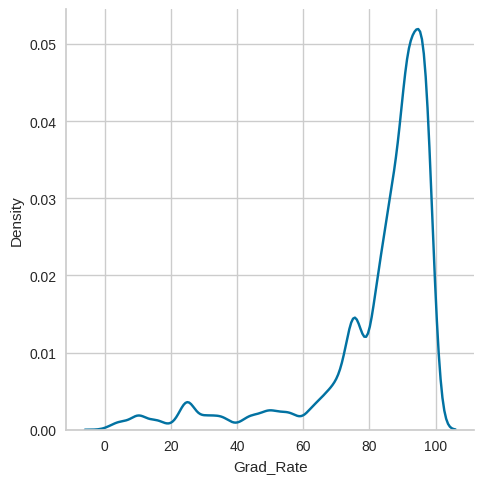

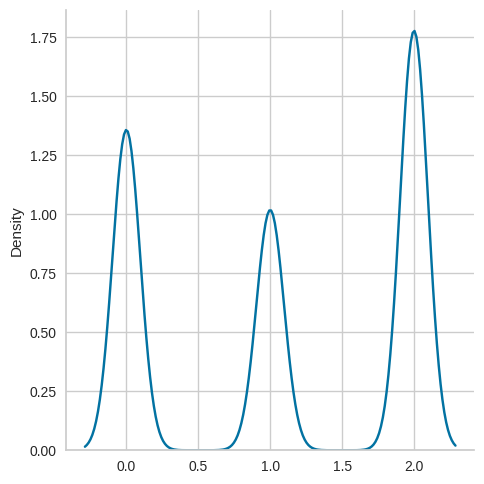

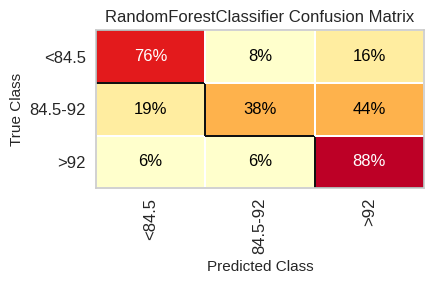

0.7153558052434457


In [15]:
from sklearn.ensemble import RandomForestClassifier
from yellowbrick.classifier import ConfusionMatrix


bins = np.percentile(ytrain, [33, 66])
ytrain_binned = np.digitize(ytrain, bins=bins)
ytest_binned = np.digitize(ytest, bins=bins)
print("Bins:", bins)
sns.displot(ytrain, kind='kde', label="continuous")
sns.displot(ytrain_binned, kind='kde', label="33,66 bins")
plt.show()


pipe = Pipeline(
    steps=[
        ("onehot", OneHotEncoder(drop_last=True, variables=Xtrain.select_dtypes(
            include='category').columns.tolist())),
        (
            "rf",
            RandomForestClassifier(
                n_jobs=4,
                max_features=0.3,
                n_estimators=800,
                max_depth=13,
                random_state=42,
            ),
        ),
    ]
)
conf = ConfusionMatrix(pipe, classes=(
    "<84.5", "84.5-92", ">92"), percent=True, size=(450, 300))
conf.fit(Xtrain, ytrain_binned)

conf.score(Xtest, ytest_binned)
conf.show()
print(conf.score_)


# Perform classification with 2 classes

Bins: [90.]


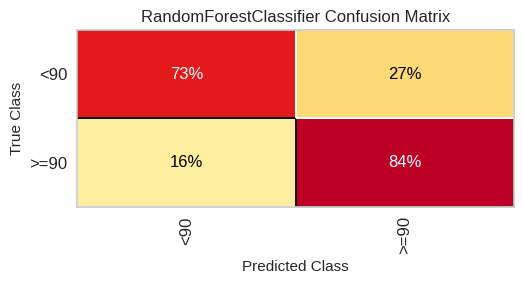

0.7891465455414775


In [16]:
# @NOTE: This model has not been optimized
# SVC rbf did a little better than poly with degree=2.

from sklearn.ensemble import RandomForestClassifier
from yellowbrick.classifier import ConfusionMatrix

bins = np.percentile(ytrain, [50])
ytrain_binned = np.digitize(ytrain, bins=bins)
ytest_binned = np.digitize(ytest, bins=bins)
print("Bins:", bins)
plt.show()

pipe = Pipeline(
    steps=[
        ("onehot", OneHotEncoder(drop_last=True, variables=Xtrain.select_dtypes(
            include='category').columns.tolist())),
        (
            "rf",
            RandomForestClassifier(
                n_jobs=4,
                max_features=0.3,
                n_estimators=800,
                max_depth=13,
                random_state=42,
            ),
        ),
    ]
)
conf = ConfusionMatrix(pipe, classes=("<90", ">=90"),
                       percent=True, size=(540, 300))
conf.fit(Xtrain, ytrain_binned)

conf.score(Xtest, ytest_binned)
conf.show()
print(conf.score_)


# Test an SVM model on the 2 class problem

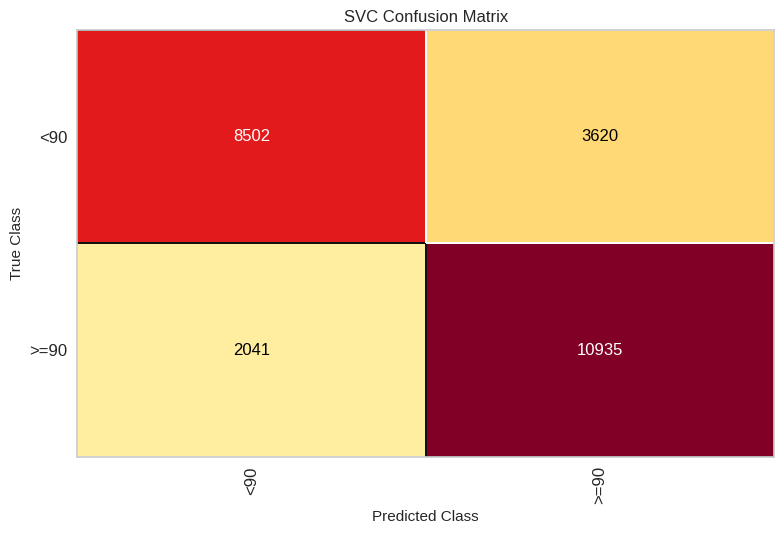

0.7744441788190294


In [17]:
from sklearn.svm import SVC
from yellowbrick.classifier import ConfusionMatrix

scaler = SklearnTransformerWrapper(transformer=StandardScaler(
), variables=Xtrain.select_dtypes(include=np.number).columns.tolist())

pipe = Pipeline(
    steps=[
        ("scaler", scaler),
        ("onehot", OneHotEncoder(drop_last=True, variables=Xtrain.select_dtypes(
            include='category').columns.tolist())),
        (
            "rf",
            SVC(
                C=1,
                kernel="rbf",
                random_state=42,
            ),
        ),
    ]
)
conf = ConfusionMatrix(pipe, classes=("<90", ">=90"))
conf.fit(Xtrain, ytrain_binned)

conf.score(Xtest, ytest_binned)
conf.show()
print(conf.score_)


# Feature Importances

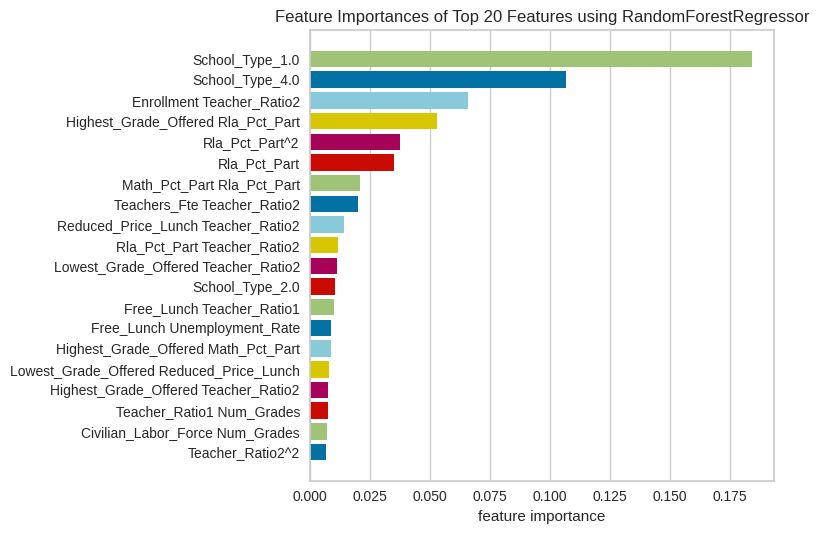

FeatureImportances(ax=<AxesSubplot: title={'center': 'Feature Importances of Top 20 Features using RandomForestRegressor'}, xlabel='feature importance'>,
                   estimator=RandomForestRegressor(max_depth=13,
                                                   max_features=0.3,
                                                   n_estimators=800, n_jobs=3),
                   relative=False, topn=20)

In [18]:
from yellowbrick.model_selection import FeatureImportances


def make_poly_onehot_pipe(X):
    scaler = SklearnTransformerWrapper(transformer=StandardScaler(
    ), variables=X.select_dtypes(include=np.number).columns.tolist())
    poly = SklearnTransformerWrapper(transformer=PolynomialFeatures(
        degree=2), variables=X.select_dtypes(include=np.number).columns.tolist())

    pipe = Pipeline(
        steps=[
            ("poly", poly),
            # ("scaler", scaler),
            ("onehot", OneHotEncoder(drop_last=True, variables=X.select_dtypes(
                include='category').columns.tolist())),
        ]
    )
    return pipe


def make_onehot_pipe(X):
    scaler = SklearnTransformerWrapper(transformer=StandardScaler(
    ), variables=X.select_dtypes(include=np.number).columns.tolist())
    poly = SklearnTransformerWrapper(transformer=PolynomialFeatures(
        degree=2), variables=X.select_dtypes(include=np.number).columns.tolist())

    pipe = Pipeline(
        steps=[
            # ("poly",poly),
            # ("scaler", scaler),
            ("onehot", OneHotEncoder(drop_last=True, variables=X.select_dtypes(
                include='category').columns.tolist())),
        ]
    )
    return pipe


def show_feature_importances(Xtrain, ytrain, topn, pipe=make_onehot_pipe(Xtrain)):
    """ Plot feature importances using RandomForestRegressor """
    viz = FeatureImportances(RandomForestRegressor(
        n_estimators=800, max_depth=13, max_features=0.3, n_jobs=3), topn=topn, relative=False)
    viz.fit(pipe.fit_transform(Xtrain), ytrain)
    viz.show()
    return viz


show_feature_importances(Xtrain, ytrain, 20, make_poly_onehot_pipe(Xtrain))


In [19]:
# Add features discovered via PolynomialFeatures
df['Enrollment Teacher_Ratio2'] = df.Enrollment * df.Teacher_Ratio2
df['Rla_Pct_Part^2'] = df.Rla_Pct_Part * df.Rla_Pct_Part
df['Highest_Grade_Offered Rla_Pct_Part'] = df.Highest_Grade_Offered * df.Rla_Pct_Part
df['Math_Pct_Part Rla_Pct_Part'] = df.Math_Pct_Part * df.Rla_Pct_Part
df['Reduced_Price_Lunch Teacher_Ratio2'] = df.Reduced_Price_Lunch * df.Teacher_Ratio2

X, y, Xtrain, Xtest, ytrain, ytest = Make_X_y(df)
pd.set_option("display.max_rows", 999)
X.dtypes


All_Cohort                               int64
Urban_Centric_Locale                  category
School_Level                          category
School_Type                           category
Lowest_Grade_Offered                   float64
Highest_Grade_Offered                  float64
Title_I_Status                        category
Title_I_Eligible                      category
Charter                               category
Magnet                                category
Virtual                               category
Teachers_Fte                           float64
Free_Lunch                             float64
Reduced_Price_Lunch                    float64
Free_Or_Reduced_Price_Lunch            float64
Enrollment                             float64
Ungrade_Cedp                          category
Math_Pct_Part                          float64
Rla_Pct_Part                           float64
Rural_Urban_Continuum_Code            category
Urban_Influence_Code                  category
Metro_Or_Not 

# Recursive Feature Elimination

Shape of X (83658, 32)
Shape opf X transformed (83658, 68)


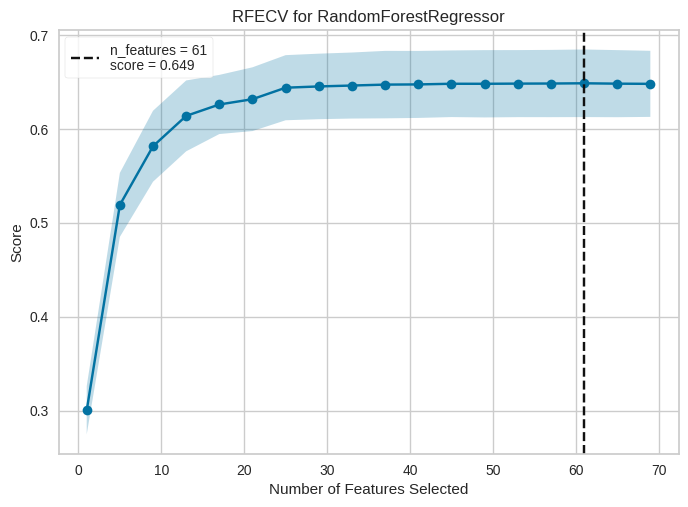

<class 'yellowbrick.model_selection.rfecv.RFECV'>


In [20]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.tree import DecisionTreeClassifier

from sklearn.model_selection import KFold
import joblib
import os
from yellowbrick.model_selection import rfecv
#
# Data points below without the polynomial terms
# recursive_feature_elimination10 - randomforestregressor with whole X_transformed and a select few poly features
#                                   cv 6, max depth 5, 59 features, 276 min
pipe = make_onehot_pipe(X)

cv = KFold(3)

print("Shape of X", X.shape)
X_transformed = pipe.fit_transform(X, y)
print("Shape opf X transformed", X_transformed.shape)

# Load visualizer from disk instead of running again.
visualizer = {}
local_file = (
    "../../student_outcome_saved_models/recursive_feature_elimination11.pkl"
)
if os.path.exists(local_file):
    visualizer = joblib.load(local_file)
else:
    visualizer = rfecv(RandomForestRegressor(n_estimators=250, max_features=0.3,
                       max_depth=10, random_state=42, n_jobs=4), step=4, X=X_transformed, y=y, cv=cv, scoring='r2', size=(675, 450))
    joblib.dump(visualizer, local_file)

print(type(visualizer))


In [21]:
cols = X_transformed.columns.tolist()
cols = pd.Series(cols)
top_feats_mask = (visualizer.ranking_ == 1)
print("num top feats:", sum(top_feats_mask))
top_features = cols.loc[top_feats_mask]

features_to_drop = set(cols) - set(top_features.to_numpy())
features_to_drop


num top feats: 61


{'Highest_Grade_Offered',
 'Ungrade_Cedp_0.0',
 'Urban_Influence_Code_10.0',
 'Urban_Influence_Code_11.0',
 'Urban_Influence_Code_12.0',
 'Urban_Influence_Code_3.0',
 'Urban_Influence_Code_4.0'}

## Conclusions
    * The recursive elimination curve produces 62 top features (with categories one-hotted)
    * Additional features beyond 30 provide minimal benefit 

# Why to remove unhelpful features
    * Reduces modeling time
    * Improves interpretability
    * Helps prevent overfitting
    * It is not really required in our case due to the size of the data

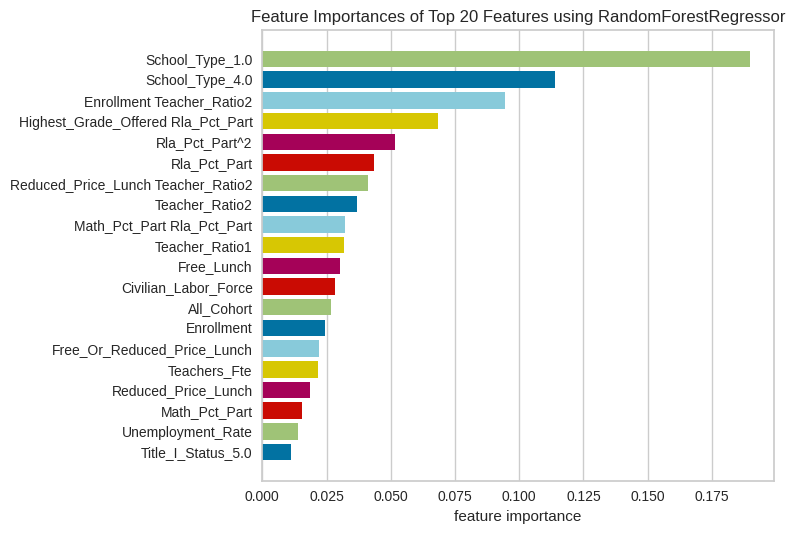

In [22]:
feature_importances = show_feature_importances(
    X, y, topn=20, pipe=make_onehot_pipe(X))


# Save two dataframes for modeling
* **dataset_feature_engineered_for_modeling.csv**
  * Only exclude features eliminated by the Recursive Feature Elimination
* **dataset_minimal_features_for_modeling.csv**
  * Top 35 features. This is 5 more than when the curve levels off to account for variation in feature importance methods, modeling methods we might use, and having suboptimal hyperparameters 

In [23]:
# Programmatically chop off all besides the top 35 features
feat_importances = feature_importances.estimator.feature_importances_
feat_names = feature_importances.estimator.feature_names_in_
print("Number of features:", len(feat_names))
assert len(feat_importances) == len(feat_names)

name_importance_pairs = list(zip(feat_importances, feat_names))
name_importance_pairs = sorted(name_importance_pairs, reverse=True)
ordered_names = []
ordered_importances = []
for importance, name in name_importance_pairs:
    ordered_names += [name]
    ordered_importances += [importance]

features_to_keep = ordered_names[:35]
print(features_to_keep)


Number of features: 68
['School_Type_1.0', 'School_Type_4.0', 'Enrollment Teacher_Ratio2', 'Highest_Grade_Offered Rla_Pct_Part', 'Rla_Pct_Part^2', 'Rla_Pct_Part', 'Reduced_Price_Lunch Teacher_Ratio2', 'Teacher_Ratio2', 'Math_Pct_Part Rla_Pct_Part', 'Teacher_Ratio1', 'Free_Lunch', 'Civilian_Labor_Force', 'All_Cohort', 'Enrollment', 'Free_Or_Reduced_Price_Lunch', 'Teachers_Fte', 'Reduced_Price_Lunch', 'Math_Pct_Part', 'Unemployment_Rate', 'Title_I_Status_5.0', 'Charter_0.0', 'Lowest_Grade_Offered', 'Urban_Centric_Locale_11.0', 'Num_Grades', 'Virtual_1.0', 'Metro_Or_Not_0.0', 'Rural_Urban_Continuum_Code_1.0', 'Urban_Influence_Code_1.0', 'Title_I_Eligible_1.0', 'Title_I_Status_6.0', 'School_Level_4.0', 'Urban_Centric_Locale_12.0', 'School_Level_3.0', 'Virtual_0.0', 'School_Type_3.0']


In [24]:
pipe = make_onehot_pipe(X)
X_transformed = pipe.fit_transform(X)
X_transformed = X_transformed[features_to_keep]
# Add in identifiers for understanding
X_transformed["Grad_Rate"] = y
X_transformed["Ncessch"] = df.Ncessch
X_transformed["Year"] = df.Year
X_transformed["Schnam"] = df.Schnam
X_transformed["Stnam"] = df.Stnam
df_minimal = X_transformed
df_minimal.to_csv(
    "../data/dataset_minimal_features_for_modeling.csv", index=False)

df_larger = pipe.fit_transform(X)
# Add in identifiers for understanding
df_larger["Grad_Rate"] = y
df_larger["Ncessch"] = df.Ncessch
df_larger["Year"] = df.Year
df_larger["Schnam"] = df.Schnam
df_larger["Stnam"] = df.Stnam
df_larger.drop(["Highest_Grade_Offered", "Ungrade_Cedp_0.0"],
               axis=1, inplace=True)
df_larger.to_csv(
    "../data/dataset_max_features_for_modeling.csv", index=False)


# Feature Visualization 

In [25]:
df_minimal.shape


(83658, 40)

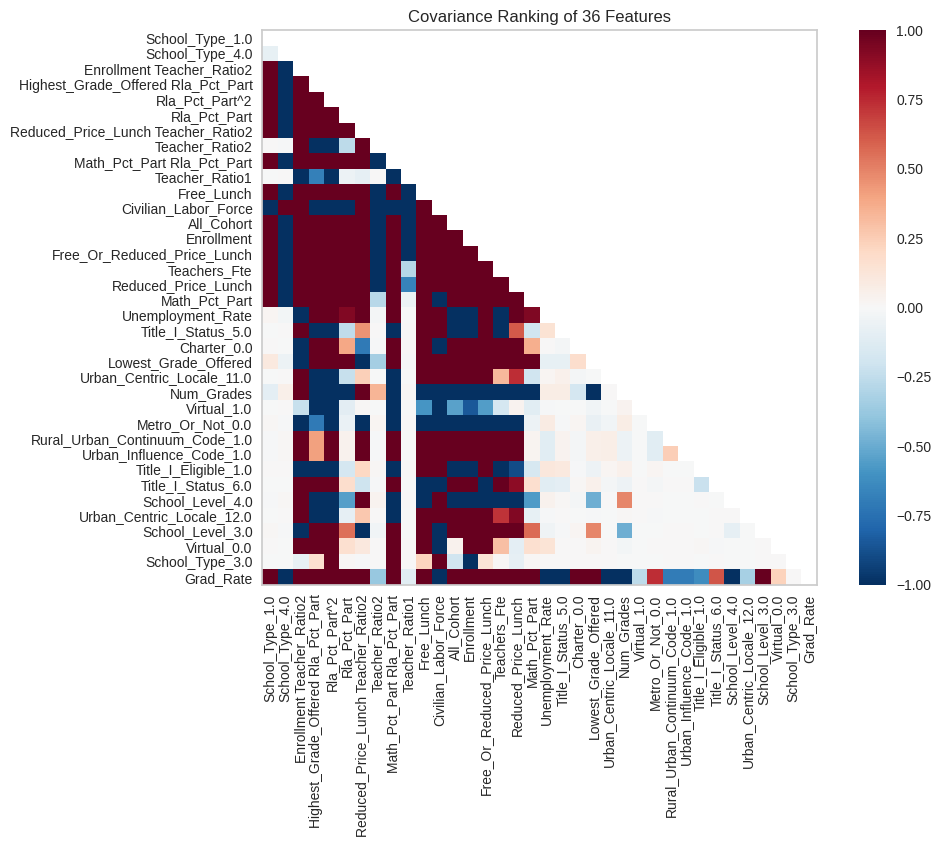

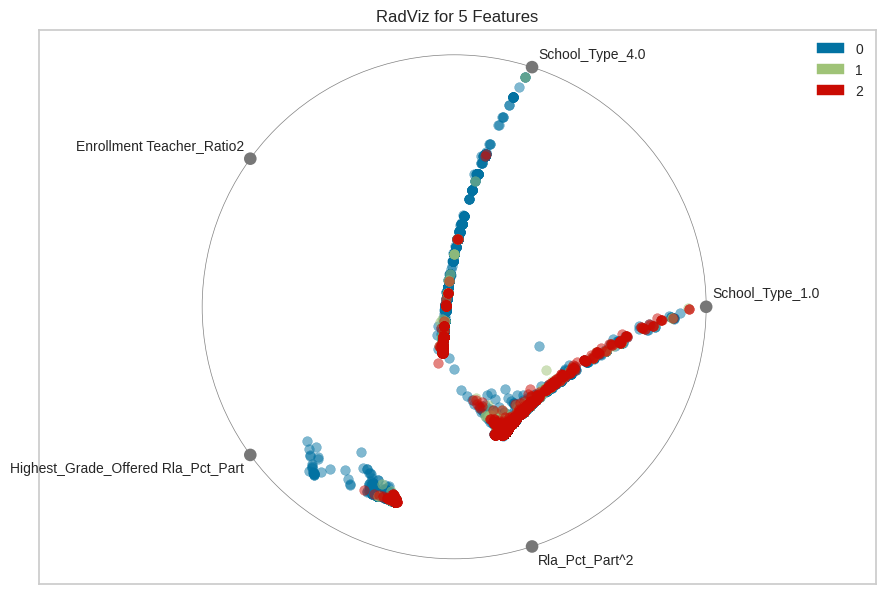

<AxesSubplot: title={'center': 'RadViz for 5 Features'}>

In [26]:
# Rad viz using equal sized blocked
# Rad viz using percentile


from yellowbrick.features import Rank2D
from yellowbrick.features import RadViz
from yellowbrick.features import ParallelCoordinates


visualizer = Rank2D(algorithm='covariance', features=(
    df_minimal[features_to_keep + ['Grad_Rate']].columns.tolist()), size=(1080, 720))
visualizer.fit(df_minimal[features_to_keep + ['Grad_Rate']], y=None)
visualizer.transform(df_minimal[features_to_keep + ['Grad_Rate']])
visualizer.show()

# Split y into 3 bins
# Rad viz using top 5 features
bins = np.percentile(y, [33, 66])
y_binned = np.digitize(y, bins=bins)
features = features_to_keep[0:5]
visualizer = RadViz(classes=None, alpha=0.5,
                    features=features, size=(1080, 720), fontsize=40)
visualizer.fit(df_minimal[features], y_binned)
visualizer.transform(df_minimal[features])
visualizer.show(fontsize=20)
